In [90]:
from statsmodels.iolib.summary2 import summary_col
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from linearmodels.panel import PanelOLS
import statsmodels.api as sm
import statsmodels.api as sm

In [91]:
url = 'https://github.com/SofiyaLyn/Thesis/raw/main/cleaned_data.csv'
cleaned_data = pd.read_csv(url)
cleaned_data.head()

,Year,Country,"Proceeds_Amount_+_Over_Sold_This_Market_(USD,_mln)",IPO_market_share,IPOs_Number_of_Issues,P/E_Ratio,E/P_ratio,Stock_Market_Index,Interest_rate_up_to_1_mln,Interest_rate_over_€1M,...,Real_GDP_Growth_(%),Population_(M),Population_Growth_(%),Real_Private_Consumption_Growth_(%),Real_Government_Consumption_Growth_(%),Real_Gross_Fixed_Investment_Growth_(%),Industrial_Production_Growth_(%),"Nominal_GDP_(EUR,B)","Real_GDP_(EUR,B)",GDP_Per_Capita_(EUR)
0,2009,Hungary,0,0,1,15,0.07,21227,0,0,...,-6,9,0,-5,1,-9,-17,94,89,9472.796711
1,2010,Hungary,179,64,4,12,0.08,21327,9,7,...,1,9,0,-1,1,-9,10,99,94,10052.830613
2,2011,Hungary,0,0,1,10,0.09,16974,9,7,...,1,9,0,0,0,-1,5,102,92,10315.512492
3,2012,Hungary,2,1,1,12,0.08,18173,10,8,...,-1,9,0,-2,0,-2,-1,100,98,10159.640779
4,2013,Hungary,1,0,1,10,0.09,18564,8,7,...,1,9,0,0,5,9,1,102,97,10393.684704


In [92]:
ipo_issues_by_country = cleaned_data.groupby('Country')['IPOs_Number_of_Issues'].sum()

# Print the data
print(ipo_issues_by_country)

Country
Albania              1
Bosnia               0
Bulgaria            24
Czechia             33
Estonia             20
Georgia              8
Hungary             15
Latvia              13
Lithuania           16
North_Macedonia      0
Poland             391
Romania             33
Serbia               4
Slovakia             8
Slovenia             2
Turkey             327
Ukraine             48
Name: IPOs_Number_of_Issues, dtype: int64


In [93]:
cleaned_data.columns = (cleaned_data.columns.str.replace('(', '_')
                        .str.replace(')', '')
                        .str.replace('%', 'Percent')
                        .str.replace('$', 'Dollar')
                        .str.replace('€', 'Euro')
                        .str.replace(',', ''))

In [94]:
print(cleaned_data.columns)

Index(['Year', 'Country', 'Proceeds_Amount_+_Over_Sold_This_Market__USD_mln',
       'IPO_market_share', 'IPOs_Number_of_Issues', 'P/E_Ratio', 'E/P_ratio',
       'Stock_Market_Index', 'Interest_rate_up_to_1_mln',
       'Interest_rate_over_Euro1M', 'Aver_interest_rate_to_nonfinance',
       'Real_GDP_Growth__Percent', 'Population__M',
       'Population_Growth__Percent',
       'Real_Private_Consumption_Growth__Percent',
       'Real_Government_Consumption_Growth__Percent',
       'Real_Gross_Fixed_Investment_Growth__Percent',
       'Industrial_Production_Growth__Percent', 'Nominal_GDP__EURB',
       'Real_GDP__EURB', 'GDP_Per_Capita__EUR'],
      dtype='object')


In [95]:
cleaned_data['treated'] = cleaned_data['Country'].isin(["Hungary", "Poland", "Slovakia", "Czech Republic", "Slovenia", "Bulgaria", "Romania", "Estonia", "Latvia", "Lithuania"])
cleaned_data['treated'] = cleaned_data['treated'].astype(int)

cleaned_data['post_intervention'] = (cleaned_data['Year'] >= 2015).astype(int)
cleaned_data['treated_intervention'] = cleaned_data['treated'] * cleaned_data['post_intervention']


print(cleaned_data.columns)

Index(['Year', 'Country', 'Proceeds_Amount_+_Over_Sold_This_Market__USD_mln',
       'IPO_market_share', 'IPOs_Number_of_Issues', 'P/E_Ratio', 'E/P_ratio',
       'Stock_Market_Index', 'Interest_rate_up_to_1_mln',
       'Interest_rate_over_Euro1M', 'Aver_interest_rate_to_nonfinance',
       'Real_GDP_Growth__Percent', 'Population__M',
       'Population_Growth__Percent',
       'Real_Private_Consumption_Growth__Percent',
       'Real_Government_Consumption_Growth__Percent',
       'Real_Gross_Fixed_Investment_Growth__Percent',
       'Industrial_Production_Growth__Percent', 'Nominal_GDP__EURB',
       'Real_GDP__EURB', 'GDP_Per_Capita__EUR', 'treated', 'post_intervention',
       'treated_intervention'],
      dtype='object')


### Simple Diff-in-Diff

In [96]:
from bs4 import BeautifulSoup
from statsmodels.iolib.summary2 import summary_col
import statsmodels.formula.api as smf


formula = 'IPOs_Number_of_Issues ~ treated + post_intervention + treated_intervention' 
model = smf.ols(formula, data=cleaned_data).fit() 

info_dict = {'R-squared' : lambda x: f"{x.rsquared:.2f}",
             'No. observations' : lambda x: f"{int(x.nobs):d}"}

summary_table = summary_col([model], stars=True, info_dict=info_dict)

soup = BeautifulSoup(summary_table.as_html(), 'html.parser')

table = soup.find('table')

table['style'] = 'border: 1px solid black'

for th in table.find_all('th'):
    th['style'] = 'text-align: center'

additional_text = soup.new_tag('div')
additional_text.string = 'Standard errors in parentheses.\n* p<.1, ** p<.05, ***p<.01'

with open('/Users/sonetalyn/Desktop/Thesis/Number of IPOs.html', 'w') as f:
    f.write(str(soup))

print(summary_table)


                     IPOs_Number_of_Issues
------------------------------------------
Intercept            5.1667***            
                     (1.7901)             
treated              0.7593               
                     (2.4602)             
post_intervention    -2.4635              
                     (2.3680)             
treated_intervention -0.6568              
                     (3.2545)             
R-squared            0.0130               
R-squared Adj.       0.0004               
R-squared            0.01                 
No. observations     238                  
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [98]:
grouped_data = cleaned_data.groupby(['Year', 'treated']).agg({'IPOs_Number_of_Issues': 'mean'}).reset_index()
sns.set(style="whitegrid")

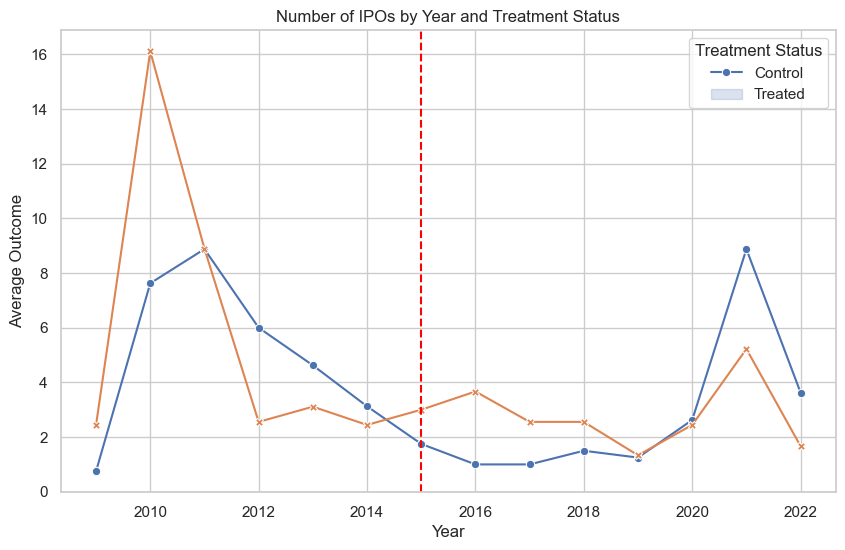

In [99]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped_data, x='Year', y='IPOs_Number_of_Issues', hue='treated', style='treated', markers=True, dashes=False)

# Adding labels and title
plt.title('Number of IPOs by Year and Treatment Status')
plt.xlabel('Year')
plt.ylabel('Average Outcome')
plt.legend(title='Treatment Status', labels=['Control', 'Treated'])
plt.axvline(x=2015, color='red', linestyle='--')
plt.savefig('/Users/sonetalyn/Desktop/Thesis/IPOs_Number_of_Issues.png')
plt.show()

### With Control Variables

In [107]:
cleaned_data['intercept'] = 1
formula = """ IPOs_Number_of_Issues ~ treated + post_intervention + treated_intervention + GDP_Per_Capita__EUR + Real_GDP__EURB + Real_Private_Consumption_Growth__Percent + Real_Government_Consumption_Growth__Percent + Real_Gross_Fixed_Investment_Growth__Percent + Industrial_Production_Growth__Percent + Population__M + intercept"""
cleaned_data['Population_Growth__Percent'] = pd.to_numeric(cleaned_data['Population_Growth__Percent'], errors='coerce')
model = smf.ols(formula, data=cleaned_data).fit()

# Defining the information to be included in the summary
info_dict = {'R-squared' : lambda x: f"{x.rsquared:.2f}",
             'No. observations' : lambda x: f"{int(x.nobs):d}"}

summary_table = summary_col([model], stars=True, info_dict=info_dict)

soup = BeautifulSoup(summary_table.as_html(), 'html.parser')

table = soup.find('table')

table['style'] = 'border: 1px solid black'

for th in table.find_all('th'):
    th['style'] = 'text-align: center'

additional_text = soup.new_tag('div')
additional_text.string = 'Standard errors in parentheses.\n* p<.1, ** p<.05, ***p<.01'

# HTML to File
with open('/Users/sonetalyn/Desktop/Thesis/Controlled IPOs Number.html', 'w') as f:
    f.write(str(soup))

print(summary_table)


                                            IPOs_Number_of_Issues
-----------------------------------------------------------------
Intercept                                   -0.6062              
                                            (1.0386)             
treated                                     3.5571               
                                            (2.2726)             
post_intervention                           -2.9483              
                                            (2.0987)             
treated_intervention                        -1.3018              
                                            (2.7839)             
GDP_Per_Capita__EUR                         -0.0000              
                                            (0.0002)             
Real_GDP__EURB                              0.0191*              
                                            (0.0103)             
Real_Private_Consumption_Growth__Percent    -0.0002              
         

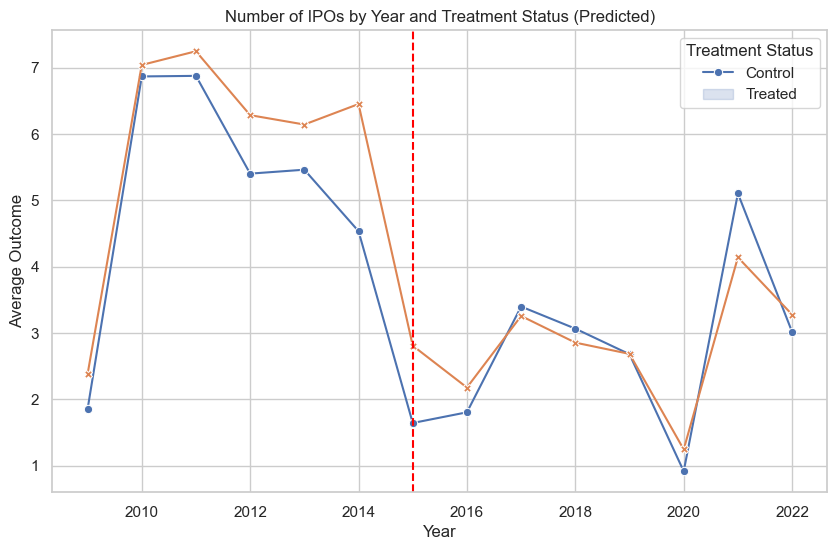

In [101]:
# Fitting the model
model = smf.ols(formula, data=cleaned_data).fit()

# Generating predicted values
cleaned_data['predicted'] = model.predict(cleaned_data)

# Grouping the data by 'Year' and 'treated', and calculate the mean of 'predicted'
grouped_data = cleaned_data.groupby(['Year', 'treated'])['predicted'].mean().reset_index()

# Creating the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped_data, x='Year', y='predicted', hue='treated', style='treated', markers=True, dashes=False)

# Adding labels and title
plt.title('Number of IPOs by Year and Treatment Status (Predicted)')
plt.xlabel('Year')
plt.ylabel('Average Outcome')
plt.legend(title='Treatment Status', labels=['Control', 'Treated'])
plt.axvline(x=2015, color='red', linestyle='--')

plt.savefig('/Users/sonetalyn/Desktop/Thesis/Controlled Number of IPOs.png')

plt.show()

## Fixed Effects with Country and Year

In [108]:
from bs4 import BeautifulSoup
from statsmodels.iolib.summary2 import summary_col
import statsmodels.formula.api as smf

formula = 'IPOs_Number_of_Issues ~ treated + post_intervention + treated_intervention + C(Country) + C(Year)' 
model = smf.ols(formula, data=cleaned_data).fit() 

info_dict = {'R-squared' : lambda x: f"{x.rsquared:.2f}",
             'No. observations' : lambda x: f"{int(x.nobs):d}"}

summary_table = summary_col([model], stars=True, info_dict=info_dict)

soup = BeautifulSoup(summary_table.as_html(), 'html.parser')

table = soup.find('table')

table['style'] = 'border: 1px solid black'

for th in table.find_all('th'):
    th['style'] = 'text-align: center'

additional_text = soup.new_tag('div')
additional_text.string = 'Standard errors in parentheses.\n* p<.1, ** p<.05, ***p<.01'

with open('/Users/sonetalyn/Desktop/Thesis/Number of IPOs with Fixed Effects.html', 'w') as f:
    f.write(str(soup))

print(summary_table)


                              IPOs_Number_of_Issues
---------------------------------------------------
Intercept                     -2.4424              
                              (3.4830)             
C(Country)[T.Bosnia]          -0.0714              
                              (3.6186)             
C(Country)[T.Bulgaria]        -1.9839              
                              (2.4316)             
C(Country)[T.Czechia]         2.2857               
                              (3.6186)             
C(Country)[T.Estonia]         -2.2696              
                              (2.4316)             
C(Country)[T.Georgia]         0.5000               
                              (3.6186)             
C(Country)[T.Hungary]         -2.6268              
                              (2.4316)             
C(Country)[T.Latvia]          -2.7696              
                              (2.4316)             
C(Country)[T.Lithuania]       -2.5553              
           

# Adding control variables

In [64]:
print(cleaned_data.columns)

Index(['Year', 'Country', 'Proceeds_Amount_+_Over_Sold_This_Market__USD_mln',
       'IPO_market_share', 'IPOs_Number_of_Issues', 'P/E_Ratio', 'E/P_ratio',
       'Stock_Market_Index', 'Interest_rate_up_to_1_mln',
       'Interest_rate_over_Euro1M', 'Aver_interest_rate_to_nonfinance',
       'Real_GDP_Growth__Percent', 'Population__M',
       'Population_Growth__Percent',
       'Real_Private_Consumption_Growth__Percent',
       'Real_Government_Consumption_Growth__Percent',
       'Real_Gross_Fixed_Investment_Growth__Percent',
       'Industrial_Production_Growth__Percent', 'Nominal_GDP__EURB',
       'Real_GDP__EURB', 'GDP_Per_Capita__EUR', 'treated', 'post_intervention',
       'treated_intervention', 'intercept'],
      dtype='object')


### Fixed Effects with Control Variables

In [110]:
from bs4 import BeautifulSoup
from statsmodels.iolib.summary2 import summary_col
import statsmodels.formula.api as smf

formula = 'IPOs_Number_of_Issues ~ treated + post_intervention + treated_intervention + C(Country) + C(Year) + GDP_Per_Capita__EUR + Real_GDP__EURB + Real_Private_Consumption_Growth__Percent + Real_Government_Consumption_Growth__Percent + Real_Gross_Fixed_Investment_Growth__Percent + Industrial_Production_Growth__Percent + Population__M' 
model = smf.ols(formula, data=cleaned_data).fit() 

info_dict = {'R-squared' : lambda x: f"{x.rsquared:.2f}",
             'No. observations' : lambda x: f"{int(x.nobs):d}"}

summary_table = summary_col([model], stars=True, info_dict=info_dict)

soup = BeautifulSoup(summary_table.as_html(), 'html.parser')

table = soup.find('table')

table['style'] = 'border: 1px solid black'

for th in table.find_all('th'):
    th['style'] = 'text-align: center'

additional_text = soup.new_tag('div')
additional_text.string = 'Standard errors in parentheses.\n* p<.1, ** p<.05, ***p<.01'

with open('/Users/sonetalyn/Desktop/Thesis/Number of IPOs with Fixed Effects.html', 'w') as f:
    f.write(str(soup))

print(summary_table)


                                            IPOs_Number_of_Issues
-----------------------------------------------------------------
Intercept                                   -10.3434**           
                                            (4.3212)             
C(Country)[T.Bosnia]                        -0.0714              
                                            (3.4405)             
C(Country)[T.Bulgaria]                      -2.6048              
                                            (4.0512)             
C(Country)[T.Czechia]                       -1.7431              
                                            (10.7721)            
C(Country)[T.Estonia]                       15.1547              
                                            (14.0397)            
C(Country)[T.Georgia]                       -2.7166              
                                            (3.5917)             
C(Country)[T.Hungary]                       -1.8832              
         

## Combined Data

In [105]:
model1 = smf.ols('IPOs_Number_of_Issues ~ treated + post_intervention + treated_intervention', data=cleaned_data).fit()
model2 = smf.ols('IPOs_Number_of_Issues ~ treated + post_intervention + treated_intervention + GDP_Per_Capita__EUR + Real_GDP__EURB + Real_Private_Consumption_Growth__Percent + Real_Government_Consumption_Growth__Percent + Real_Gross_Fixed_Investment_Growth__Percent + Industrial_Production_Growth__Percent + Population__M', data=cleaned_data).fit()
model3 = smf.ols('IPOs_Number_of_Issues ~ treated + post_intervention + treated_intervention + C(Country) + C(Year)', data=cleaned_data).fit()
model4 = smf.ols('IPOs_Number_of_Issues ~ treated + post_intervention + treated_intervention + C(Country) + C(Year) + GDP_Per_Capita__EUR + Real_GDP__EURB + Real_Private_Consumption_Growth__Percent + Real_Government_Consumption_Growth__Percent + Real_Gross_Fixed_Investment_Growth__Percent + Industrial_Production_Growth__Percent + Population__M', data=cleaned_data).fit()

summary_table = summary_col([model1, model2, model3, model4], stars=True, info_dict=info_dict)

soup = BeautifulSoup(summary_table.as_html(), 'html.parser')

table = soup.find('table')

table['style'] = 'border: 1px solid black'

for th in table.find_all('th'):
    th['style'] = 'text-align: center'

additional_text = soup.new_tag('div')
additional_text.string = 'Standard errors in parentheses.\n* p<.1, ** p<.05, ***p<.01'

soup.append(additional_text)

with open('/Users/sonetalyn/Desktop/Thesis/Combined_Models_IPOs.html', 'w') as f:
    f.write(str(soup))

# Print the summary table
print(summary_table)


                                            IPOs_Number_of_Issues I IPOs_Number_of_Issues II IPOs_Number_of_Issues III IPOs_Number_of_Issues IIII
-------------------------------------------------------------------------------------------------------------------------------------------------
C(Country)[T.Bosnia]                                                                         -0.0714                   -0.0714                   
                                                                                             (3.6186)                  (3.4405)                  
C(Country)[T.Bulgaria]                                                                       -1.9839                   -2.6048                   
                                                                                             (2.4316)                  (4.0512)                  
C(Country)[T.Czechia]                                                                        2.2857                    -1.7